### Process Followed
#### 1. Get the restaurant reviews
#### 2. Classify negative < 3 positive >=3. and put as a target column 'Actual_Sentiment'
#### 3. Clean the data defining a function 'function_clean'
#### 4. Split into train test dataset
#### 5. Tokenize
#### 6. Lemmatize
#### 7. Remove Stopwords
#### 8. Vectorizing the text using TF_IDF
#### 9. Balance the dataset (I used SMOTE from imblearn)
#### 10. Quick test fitting a logistic model
### Sentiment Model Evaluation and Selection
#### 1a. Create a Baseline Classification Model
#### 1b. Get the prediction accuracy and create ConfusionMetric, ClassificationReport,  ROCAUC  curve for the Baseline Classification Model
#### 2a. Create a Logistic Regression model
#### 2b. Get the prediction accuracy and create ConfusionMetric, ClassificationReport,  ROCAUC  curve for the Logistic Regression Model
#### 2c. hyperparameter tuning-> Grid search (logistic) For optimal parameter C in Logistic Regression model
#### 3a. Create a Random Forest model
#### 3b. Get the prediction accuracy and create ConfusionMetric, ClassificationReport,  ROCAUC  curve for the Random Forest  Model
#### 3c. hyperparameter tuning-> For optimal n_estimators parameter in Random Forest  model
#### 4a. Create aXGboost model
#### 4b. Get the prediction accuracy and create ConfusionMetric, ClassificationReport,  ROCAUC  curve for the aXGboost Model
#### 5. Choose the best model via training set prediction accuracy
#### 6. Test of Positive and Negative reviews using all 3 models.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC


In [4]:
from azureml.core import Workspace, Dataset, Datastore
subscription_id = 'Redacted'
resource_group = 'calcutta_demos'
workspace_name = 'Houston-techsummit-workspace'

workspace = Workspace(subscription_id, resource_group, workspace_name)

In [6]:
#Get the yelp Dataset from adlsgen2
dataset_yelp_review = Dataset.get_by_name(workspace, 'yelp_review')
dataset_yelp_review.take(3).to_pandas_dataframe()

,review_id,business_id,stars,useful,funny,cool,date,text,user_id
0,xQY8N_XvtGbearJ5X4QryQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,2015-04-15,"As someone who has worked with many museums, I...",OwjRMXRC0KyPrIlcjaXeFQ
1,UmFMZ8PyXZTY2QcwzsfQYA,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,2013-12-07,I am actually horrified this place is still in...,nIJD_7ZXHq-FX8byPMOkMQ
2,LG2ZaYiOgpr2DK_90pYjNw,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,2015-12-05,I love Deagan's. I do. I really do. The atmosp...,V34qejxNsCbcgD8C0HVk-Q


In [7]:
#Conver to Pandas Dataframe
df_yelp_review = dataset_yelp_review.to_pandas_dataframe()

In [8]:
df_yelp_review.count()

review_id      1009534
business_id    1009534
stars          1009534
useful         1009534
funny          1009534
cool           1009534
date           1009534
text           1009534
user_id        1009534
dtype: int64

In [9]:
df_yelp_review = df_yelp_review[:100000]

In [10]:
df_yelp_review.count()

review_id      100000
business_id    100000
stars          100000
useful         100000
funny          100000
cool           100000
date           100000
text           100000
user_id        100000
dtype: int64

In [11]:
# Create new column "Actual_Sentiment" that stored 0's or 1's.
# 0 being Negative, 1 being Positive
import numpy as np
df_yelp_review["Actual_Sentiment"] = np.where(df_yelp_review["stars"] >= 3, 1, 0)
df_yelp_review.head(3)

,review_id,business_id,stars,useful,funny,cool,date,text,user_id,Actual_Sentiment
0,xQY8N_XvtGbearJ5X4QryQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,2015-04-15,"As someone who has worked with many museums, I...",OwjRMXRC0KyPrIlcjaXeFQ,0
1,UmFMZ8PyXZTY2QcwzsfQYA,lbrU8StCq3yDfr-QMnGrmQ,1,1,1,0,2013-12-07,I am actually horrified this place is still in...,nIJD_7ZXHq-FX8byPMOkMQ,0
2,LG2ZaYiOgpr2DK_90pYjNw,HQl28KMwrEKHqhFrrDqVNQ,5,1,0,0,2015-12-05,I love Deagan's. I do. I really do. The atmosp...,V34qejxNsCbcgD8C0HVk-Q,1


In [12]:
#We only need the text (review) and Actual_Sentiment columns for sentiment prediction
df_ml_yelp_review = df_yelp_review[['text','Actual_Sentiment']]
df_ml_yelp_review.head(5)

,text,Actual_Sentiment
0,"As someone who has worked with many museums, I...",0
1,I am actually horrified this place is still in...,0
2,I love Deagan's. I do. I really do. The atmosp...,1
3,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",0
4,"Oh happy day, finally have a Canes near my cas...",1


In [13]:
df_ml_yelp_review.shape

(100000, 2)

In [14]:
#Build punctuation dictionary
import unicodedata
import sys

# Create a dictionary of punctuation characters
punctuation = dict.fromkeys(i for i in range(sys.maxunicode)
                            if unicodedata.category(chr(i)).startswith('P'))
# Add the backtick/ Grave accent character
punctuation.update({96:None})

In [15]:
#Cant use \W as it strips the spaces
s = 'ab5z8d *$&Y@#'
#regx = re.compile('\W')
#result = regx.findall(s)
s = re.sub('\W', "", s)
print (s)


ab5z8dY


In [16]:
#Let us clean up and make the data ready
import re 
def function_clean(text):
    #convert into lowercase
    text = text.lower()
    #removing the URL Http
    text = re.sub(r"http\S+", "", text) 
    # Removal of mentions
    #text = re.sub("@[^\s]*", "", text)
    # Removal of hashtags
    #text = re.sub("#[^\s]*", "", text)
    # Removal of numbers
    text = re.sub('[0-9]*[+-:]*[0-9]+', '', text)
    text = re.sub("'s", "", text)   
    #remove all punctuation from the text.
    text = str(text.translate(punctuation))
    
    return text

In [17]:
# applying the cleaning function to text column
df_ml_yelp_review['text'] = df_ml_yelp_review['text'].apply(lambda text: function_clean(text))

In [18]:
df_ml_yelp_review.head(5)

,text,Actual_Sentiment
0,as someone who has worked with many museums i ...,0
1,i am actually horrified this place is still in...,0
2,i love deagan i do i really do the atmosphere ...,1
3,dismal lukewarm defrostedtasting texmex glop\n...,0
4,oh happy day finally have a canes near my casa...,1


In [19]:
#Splitting the data to train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df_ml_yelp_review["text"]
y = df_ml_yelp_review["Actual_Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [20]:
y.value_counts()

1    78072
0    21928
Name: Actual_Sentiment, dtype: int64

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000,), (20000,), (80000,), (20000,))

In [22]:
#Now it is time to preprocess the reviews because all these modifications will directly affect the classifier’s performance.
# As we are going to use words as features so we can use some text formatting techniques which will help us in feature extraction
#  including removing punctuation marks/digits ,and also stop-words. In addition, the implementation of lemmatization words using NLTK
#   can be workable to maximize the performance. Tokenization is the last step to break reviews up into words and other meaningful tokens.
import string
#pip install nltk
import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):

    listofwords = sentence.strip().split()          # to remove any space from beginning and the end of text
    tokenized_words = []    
    for word in listofwords:
        if not word in ENGLISH_STOP_WORDS:
            lemm_word = WordNetLemmatizer().lemmatize(word)
            if len(lemm_word)>0:
                tokenized_words.append(lemm_word)
    return(tokenized_words)

In [19]:
#lem = nltk.stem.wordnet.WordNetLemmatizer()
#nltk.download('wordnet')

In [23]:
#Vectorizing the text using TF_IDF

#By implementing the sklearn library, we can use TF_IDF vectorizing to find 
#the weighted words that occur more frequently in the document that leads to
# creation of the bag of words model. So our features will be the words or sequence of
# words of these reviews. We are going to explore different models with
# the combinations of n_grams (unigrams,bigrams,trigrams).
#min_df float or int, default=1
#When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold.
# This value is also called cut-off in the literature. If float in range of [0.0, 1.0], 
# the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

#ngram_rangetuple (min_n, max_n), default=(1, 1)
#The lower and upper boundary of the range of n-values for different n-grams to be extracted. All values of n such 
#that min_n <= n <= max_n will be used. For example an ngram_range of (1, 1) means only unigrams, (1, 2) means
# unigrams and bigrams, and (2, 2) means only bigrams. Only applies if analyzer is not callable.

#tokenizer callable, default=None
#Override the string tokenization step while preserving the preprocessing and n-grams generation steps. 
#Only applies if analyzer == 'word'.


from sklearn.feature_extraction.text import TfidfVectorizer
vect_1 = TfidfVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words={'english'}, ngram_range=(1,3)).fit(X_train)
X_train1 = vect_1.transform(X_train)
X_test1 = vect_1.transform(X_test)


In [24]:
#counting most repetitive words 
word_counts = np.array(np.sum(X_train1, axis=0)).reshape((-1,))
words = np.array(vect_1.get_feature_names())
words_df = pd.DataFrame({"word":words, "count":word_counts})
words_df.sort_values(by="count",ascending=False).head(20)

,word,count
1886,food,2350.741677
3851,place,2267.291804
2336,great,2257.197188
2215,good,2159.513597
4586,service,1828.722338
5258,time,1747.057101
2988,like,1445.426751
2104,get,1438.455248
3585,one,1391.131842
338,back,1365.544471


In [25]:
#pip install sklearn --upgrade
#pip install -U imbalanced-learn
#pip install imblearn
#pip install delayed


In [26]:
#The only challenge that we’ve faced was about balancing the train dataset in terms of having the equal 
#numbers of positive and negative reviews for our two classes. 
#So we are using SMOTE to balanace our target(class) column.
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

#SMOTE the training data
sm = SMOTE(random_state=1)
X_bal, y_bal = sm.fit_resample(X_train1, y_train)


In [27]:
X_bal.shape

(124806, 5959)

In [28]:
print(type(X_bal))

<class 'scipy.sparse.csr.csr_matrix'>


In [29]:
y_bal.value_counts()

1    62403
0    62403
Name: Actual_Sentiment, dtype: int64

## Sentiment Model Evaluation and Selection

### 1a. Create a Baseline Classification Model



In [83]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='uniform', random_state=1)

# "Train" model
dummy.fit(X_bal, y_bal)

# Get accuracy score
dummy.score(X_test1,y_test)

0.49975

### 1b. Get the prediction accuracy and create ConfusionMetric, ClassificationReport,  ROCAUC  curve for the Baseline Classification Model

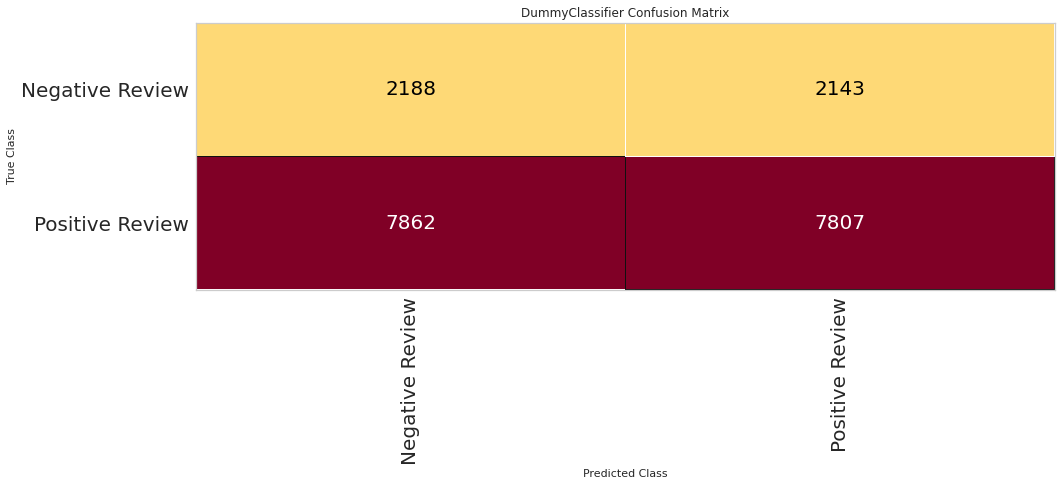

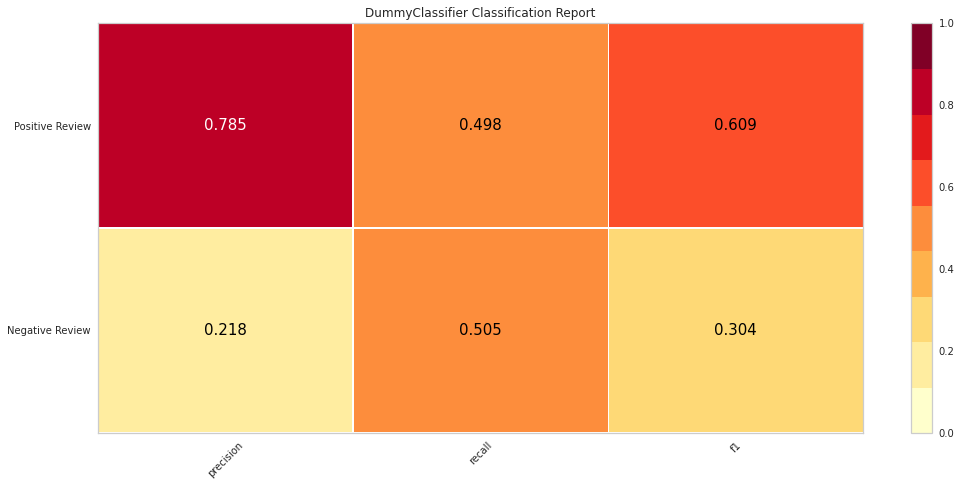

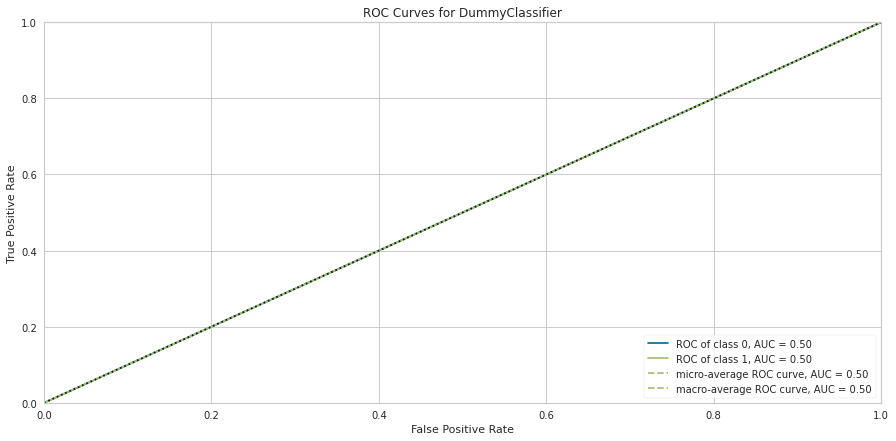

In [84]:
classes = ['Negative Review','Positive Review']
cm = ConfusionMatrix(dummy, classes=classes, percent=False)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)


#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test1,y_test)

# change fontsize of the labels in the figure
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 15
#How did we do?
cm.poof()

# Instantiate the visualizer
visualizer = ClassificationReport(dummy, classes=classes)
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(dummy)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.fit(X_bal, y_bal)
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
plt.rcParams['font.size'] = 20
g = visualizer.poof()

### By comparing the baseline classifier to our trained classifier, we can see the improvements.



### 2a. Create a Logistic Regression model

In [30]:
# fitting a logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Fitting Logistic regression to the training set
logreg = LogisticRegression(solver='lbfgs',multi_class='auto',random_state=1)
logreg.fit(X_bal, y_bal)

# Predicting the test set results
y_pred_logreg = logreg.predict(X_test1)

# Training score
print(f"Score on training set: {logreg.score(X_train1,y_train)}")
print(f"Score on test set: {logreg.score(X_test1,y_test)}")

Score on training set: 0.9217
Score on test set: 0.9069


### 2b. Get the prediction accuracy and create ConfusionMetric, ClassificationReport,  ROCAUC  curve for the Logistic Regression Model

In [31]:
from sklearn.metrics import classification_report
print('The Confusion Matrix')
con_mat_lr = confusion_matrix(y_test, y_pred_logreg)
df_cm_lr = pd.DataFrame(con_mat_lr, columns = ['Predicted 0','Predicted 1'], index = ['True 0','True 1'])
display(df_cm_lr)

The Confusion Matrix


,Predicted 0,Predicted 1
True 0,3823,508
True 1,1354,14315


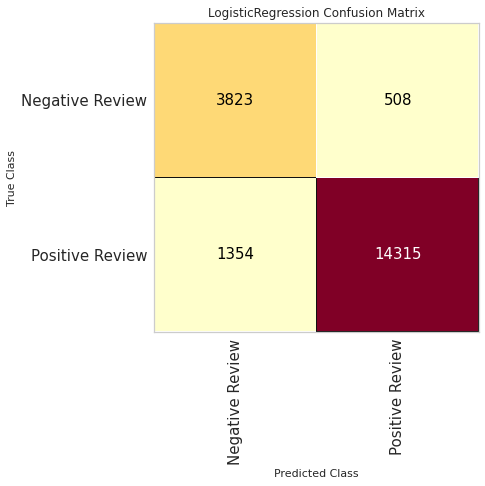

In [61]:
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Instantiate the classification model 
#logreg
#The ConfusionMatrix visualizer taxes a model
classes = ['Negative Review','Positive Review']
cm = ConfusionMatrix(logreg, classes=classes, percent=False)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)


#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test1,y_test)

# change fontsize of the labels in the figure
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams['font.size'] = 15
#How did we do?
cm.poof()


In [31]:
print('The Classification report')
report = classification_report(y_test, y_pred_logreg, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

The Classification report


,precision,recall,f1-score,support
0,0.738459,0.882706,0.804165,4331.0000
1,0.965729,0.913587,0.938935,15669.0000
accuracy,0.906900,0.906900,0.906900,0.9069
macro avg,0.852094,0.898147,0.871550,20000.0000
weighted avg,0.916514,0.906900,0.909750,20000.0000


#### Model Evaluation
As shown above, our model test accuracy is 0.90. In order to evaluate the model further, we can extract some important evaluation metrics from the classification report such as precision, recall, and f1_score. As shown in the following report, as the f1_score is 0.93 for class 1 and 0.8 for class 0, therefore we can conclude this model is better in predicting positive reviews than negative ones.

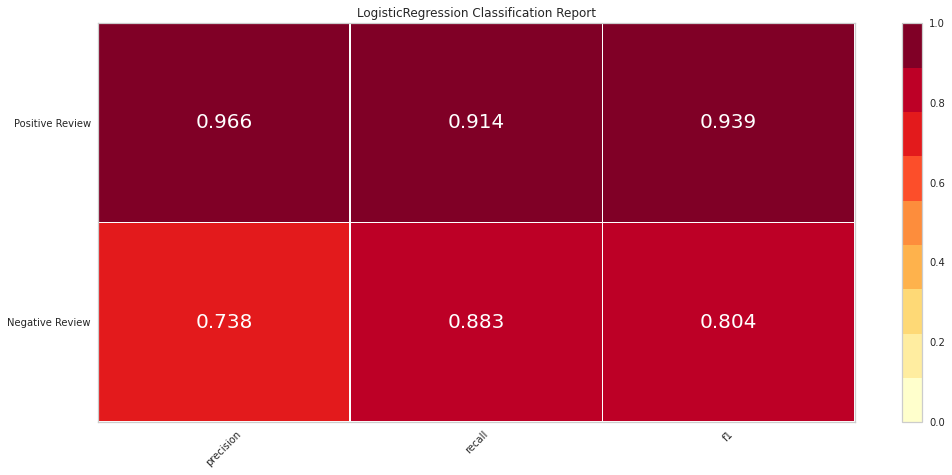

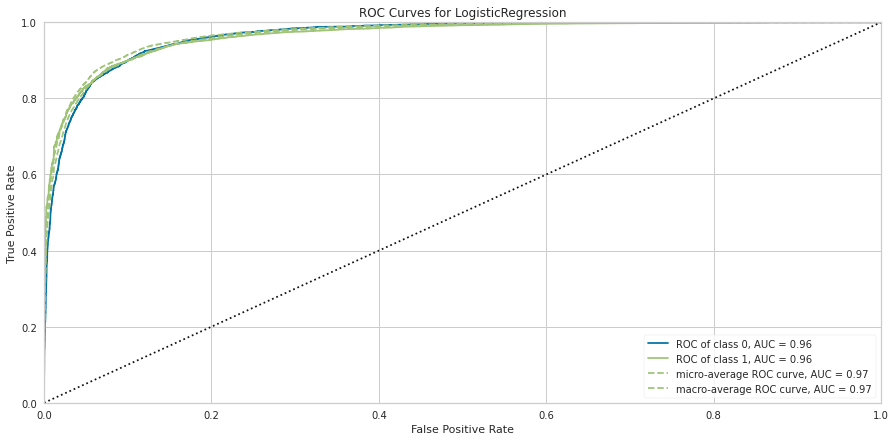

In [59]:
# Precision, Recall, and F1 Score
# set the size of the figure and the font size 
#%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 20

# Instantiate the visualizer
visualizer = ClassificationReport(logreg, classes=classes)
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(logreg)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.fit(X_bal, y_bal)
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
plt.rcParams['font.size'] = 20
g = visualizer.poof()

### 2c. hyperparameter tuning-> Grid search (logistic) For optimal parameter C in Logistic Regression model
Grid search (logistic) -> hyperparameter tuning
Let's now try to optimize some hyperparameters. We will start off with the logistic regression by finding out the optimal value for parameter C by applying the Grid search.

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

estimators = [('classifier',LogisticRegression(solver='lbfgs',multi_class='auto',random_state=1))]
pipe = Pipeline(estimators)

params = {'classifier__C' : [10**j for j in range(-4,4)]}
grid_search = GridSearchCV(pipe, param_grid=params,cv=5)

In [63]:
fitted_search = grid_search.fit(X_bal, y_bal)

In [64]:
fitted_search.best_estimator_

Pipeline(steps=[('classifier', LogisticRegression(C=10, random_state=1))])

After grid search we found our optimal parameter and applied in the our model. As a result, the train and test accuracy slightly are increased.

In [65]:
logreg = LogisticRegression(C=10, random_state=1)
logreg.fit(X_bal, y_bal)

# Predicting the test set results
y_pred_logreg = logreg.predict(X_test1)

# Training score
print(f"Score on training set: {logreg.score(X_train1,y_train)}")
print(f"Score on test set: {logreg.score(X_test1,y_test)}")

# Creating confusion matrix/ dataFrame
con_mat_lr = confusion_matrix(y_test, y_pred_logreg)
df_cm_lr = pd.DataFrame(con_mat_lr, columns = ['Predicted 0','Predicted 1'], index = ['True 0','True 1'])
df_cm_lr

Score on training set: 0.935275
Score on test set: 0.9079


,Predicted 0,Predicted 1
True 0,3756,575
True 1,1267,14402


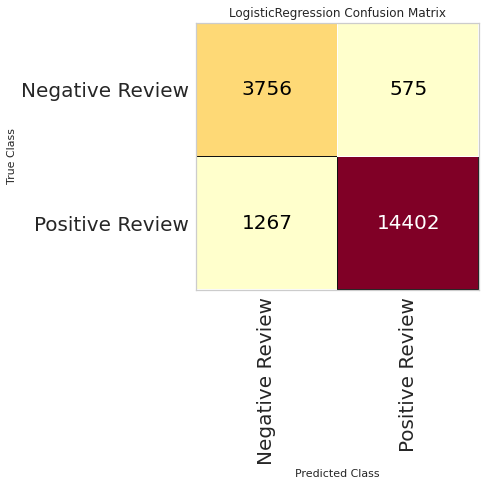

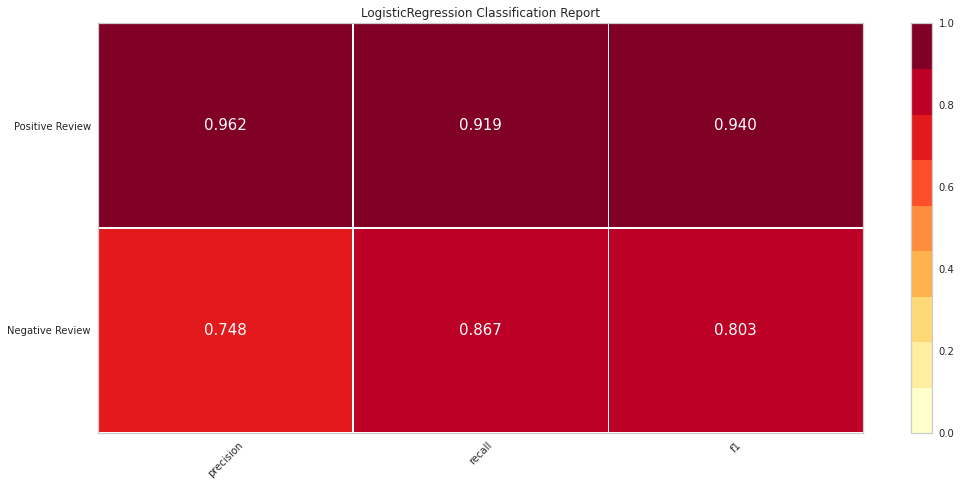

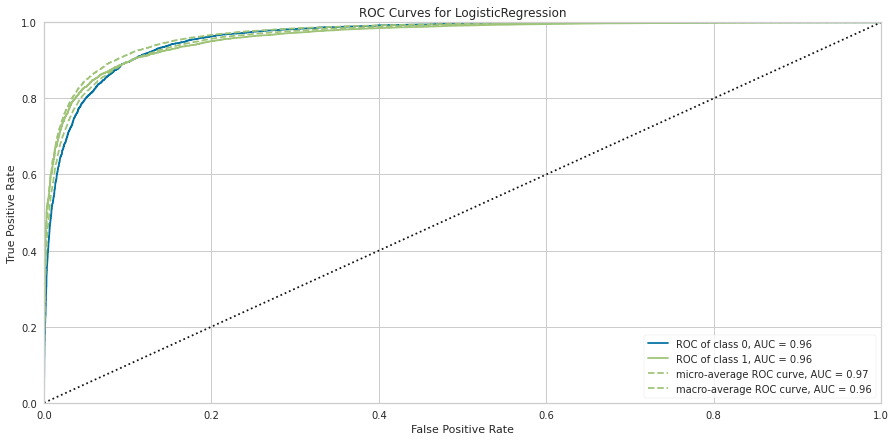

In [67]:
classes = ['Negative Review','Positive Review']
cm = ConfusionMatrix(logreg, classes=classes, percent=False)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)


#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test1,y_test)

# change fontsize of the labels in the figure
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 15
#How did we do?
cm.poof()

# Instantiate the visualizer
visualizer = ClassificationReport(logreg, classes=classes)
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(logreg)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.fit(X_bal, y_bal)
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
plt.rcParams['font.size'] = 20
g = visualizer.poof()

### 3a. Create a Random Forest model

In [68]:
from sklearn.ensemble import RandomForestClassifier

my_random_forest = RandomForestClassifier(random_state=1)
my_random_forest.fit(X_bal, y_bal)
print(f"Random Forest: {my_random_forest.score(X_bal, y_bal)}")
print(f"Random Forest: {my_random_forest.score(X_test1, y_test)}")

Random Forest: 0.9999439129529029
Random Forest: 0.8916


In [69]:
print(f"Score on training set: Random Forest: {my_random_forest.score(X_bal, y_bal)}")
print(f"Score on test set: Random Forest: {my_random_forest.score(X_test1, y_test)}")

Score on training set: Random Forest: 0.9999439129529029
Score on test set: Random Forest: 0.8916


### 3b. hyperparameter tuning-> For optimal n_estimators parameter in Random Forest  model
To find the optimal n_estimators parameter, we are going to try various number of n_estimators as shown below.

In [70]:
dt_train=[]
dt_test=[]
depth=[]
for i in range(1,20):
    my_random_forest = RandomForestClassifier(n_estimators=i,random_state=1)
    my_random_forest.fit(X_bal, y_bal)
    dt_train.append(my_random_forest.score(X_bal, y_bal))
    dt_test.append(my_random_forest.score(X_test1, y_test))
    depth.append(i)

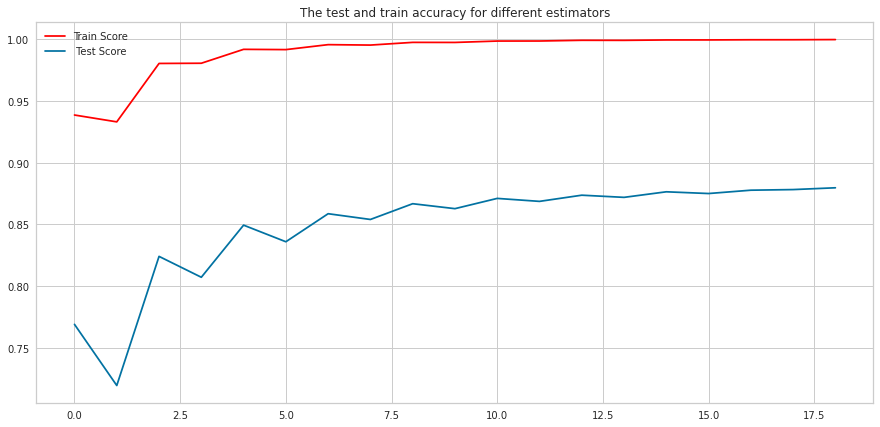

19


In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure()
plt.title('The test and train accuracy for different estimators')
plt.plot(dt_train,color='red',label='Train Score')
plt.plot(dt_test,label=' Test Score')
plt.legend()
plt.show()
print(depth[np.argmax(dt_test)])

### Now we found the optimal n_estimators as 14, the both train and test accuracy are increased.

In [72]:
my_random_forest = RandomForestClassifier(n_estimators=14,random_state=1)
my_random_forest.fit(X_bal, y_bal)
print(f"Random Forest train: {my_random_forest.score(X_bal, y_bal)}")
print(f"Random Forest test: {my_random_forest.score(X_test1, y_test)}")

Random Forest train: 0.9990385077640498
Random Forest test: 0.8719


In [73]:
# Predicting the test set results
y_pred_rand = my_random_forest.predict(X_test1)

### 3c. Get the prediction accuracy and create ConfusionMetric, ClassificationReport,  ROCAUC  curve for the Random Forest Model

In [74]:
# Creating confusion matrix/ dataFrame
con_mat_RF = confusion_matrix(y_test, y_pred_rand)
df_cm_RF = pd.DataFrame(con_mat_RF, columns = ['Predicted 0','Predicted 1'], index = ['True 0','True 1'])
df_cm_RF

,Predicted 0,Predicted 1
True 0,3103,1228
True 1,1334,14335


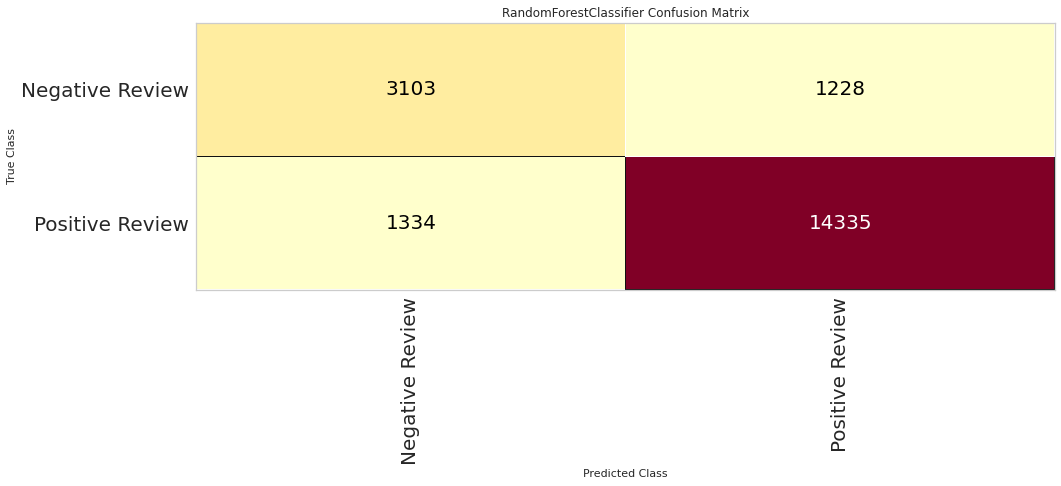

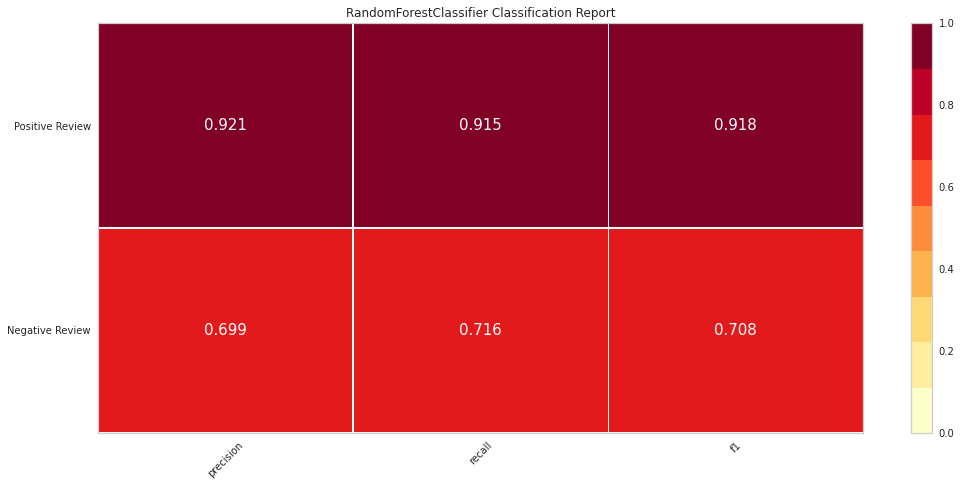

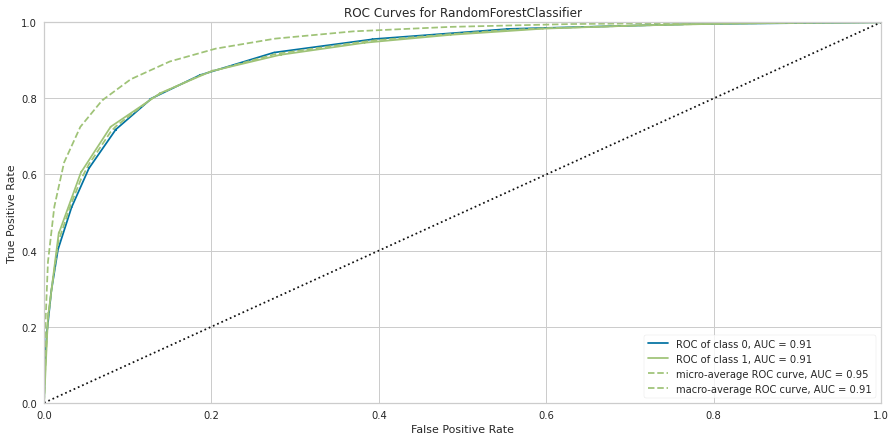

In [75]:
classes = ['Negative Review','Positive Review']
cm = ConfusionMatrix(my_random_forest, classes=classes, percent=False)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)


#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test1,y_test)

# change fontsize of the labels in the figure
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 15
#How did we do?
cm.poof()

# Instantiate the visualizer
visualizer = ClassificationReport(my_random_forest, classes=classes)
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(my_random_forest)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.fit(X_bal, y_bal)
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
plt.rcParams['font.size'] = 20
g = visualizer.poof()

### 4a. Create aXGboost model

In [76]:
from xgboost import XGBClassifier

XGB_model = XGBClassifier(random_state=1)
XGB_model.fit(X_bal, y_bal)

print(f"XG Boost train score: {XGB_model.score(X_bal, y_bal)}")
print(f"XG Boost test score: {XGB_model.score(X_test1, y_test)}")

XG Boost train score: 0.8793086870823518
XG Boost test score: 0.8409


### 4b. Get the prediction accuracy and create ConfusionMetric, ClassificationReport,  ROCAUC  curve for the aXGboost Model

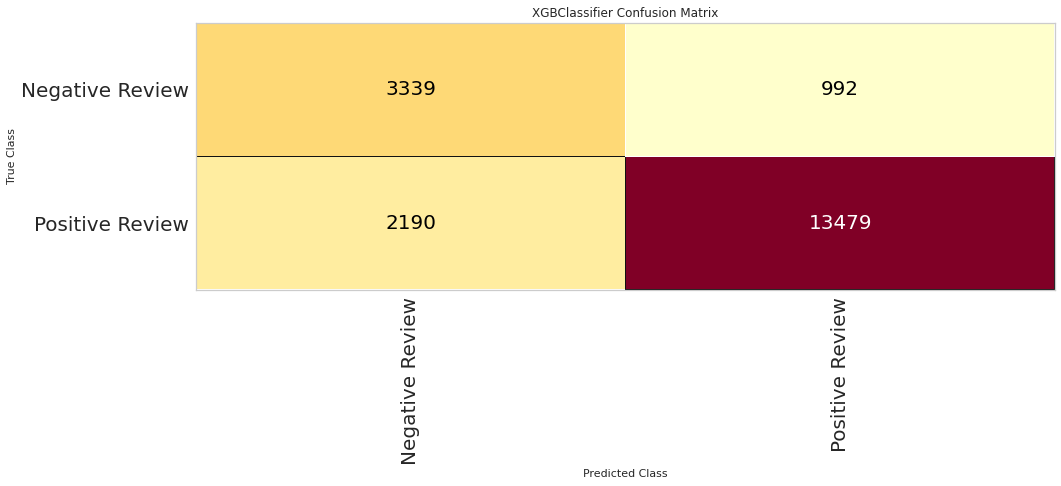

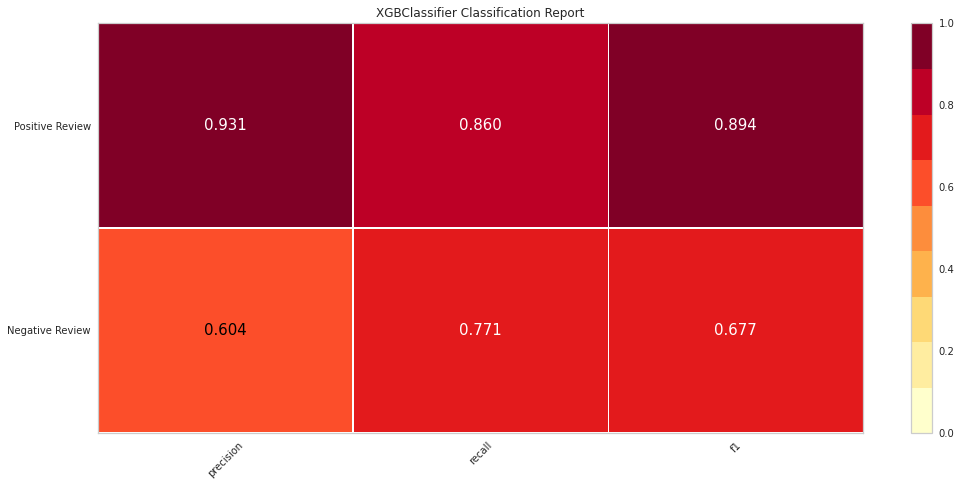

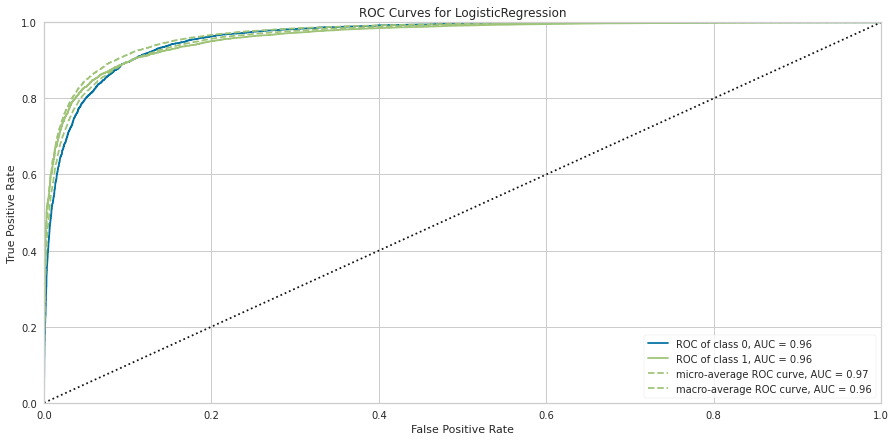

In [77]:
classes = ['Negative Review','Positive Review']
cm = ConfusionMatrix(XGB_model, classes=classes, percent=False)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
#cm.fit(X_train, y_train)


#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test1,y_test)

# change fontsize of the labels in the figure
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 15
#How did we do?
cm.poof()

# Instantiate the visualizer
visualizer = ClassificationReport(XGB_model, classes=classes)
#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
g = visualizer.poof()

# ROC and AUC
#Instantiate the visualizer
visualizer = ROCAUC(logreg)

#visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.fit(X_bal, y_bal)
visualizer.score(X_test1,y_test)  # Evaluate the model on the test data
plt.rcParams['font.size'] = 20
g = visualizer.poof()

### 5. Choose the best model via training set prediction accuracy
### Results: Among all the three models, the Logistic Regression gave us the highest test accuracy score as 0.90 and after that the RandomForest with 0.87 followed by aXGboost with an accuracy of 0.84

### 6. Test of Positive and Negative reviews using all 3 models.
#### In this stage, after creating the different classification models, now we can use them to predict the sentiment of the restaurant reviews.

#### (Negative review):
#### "The waiting time was really long."

In [78]:
input_string = "The waiting time was really long."
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_1.transform([function_clean(input_string)])))
print("Random Forest model      :",my_random_forest.predict(vect_1.transform([function_clean(input_string)])))
print("XGboost model            :",XGB_model.predict(vect_1.transform([function_clean(input_string)])))


Prediction on an input string: The waiting time was really long.
Logistic Regression model: [0]
Random Forest model      : [0]
XGboost model            : [0]


#### (Negative review):
#### "I haven't had a lunch this bad for a really long time.  It was disgusting!"

In [79]:
input_string = "I haven't had a lunch this bad for a really long time.  It was disgusting!."
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_1.transform([function_clean(input_string)])))
print("Random Forest model      :",my_random_forest.predict(vect_1.transform([function_clean(input_string)])))
print("XGboost model            :",XGB_model.predict(vect_1.transform([function_clean(input_string)])))


Prediction on an input string: I haven't had a lunch this bad for a really long time.  It was disgusting!.
Logistic Regression model: [0]
Random Forest model      : [0]
XGboost model            : [0]


#### (Positive review)
#### "people that works here for sure is friendly! :) I do love that big menu."

In [80]:
input_string = " people that works here for sure is friendly! :)I do love that big menu book and seems like there are a lot of items to choose from. This is always nice as Vietnamese food is definitely more than pho and more spring rolls."
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_1.transform([function_clean(input_string)])))
print("Random Forest model      :",my_random_forest.predict(vect_1.transform([function_clean(input_string)])))
print("XGboost model            :",XGB_model.predict(vect_1.transform([function_clean(input_string)])))


Prediction on an input string:  people that works here for sure is friendly! :)I do love that big menu book and seems like there are a lot of items to choose from. This is always nice as Vietnamese food is definitely more than pho and more spring rolls.
Logistic Regression model: [1]
Random Forest model      : [1]
XGboost model            : [1]


#### (Positive review)
#### "The staff is friendly, and the food is good. They have a good selection of drinks"

In [81]:
input_string = "The staff is friendly, and the food is good. They have a good selection of drinks"
print("\nPrediction on an input string: " + input_string)
print("Logistic Regression model:",logreg.predict(vect_1.transform([function_clean(input_string)])))
print("Random Forest model      :",my_random_forest.predict(vect_1.transform([function_clean(input_string)])))
print("XGboost model            :",XGB_model.predict(vect_1.transform([function_clean(input_string)])))


Prediction on an input string: The staff is friendly, and the food is good. They have a good selection of drinks
Logistic Regression model: [1]
Random Forest model      : [1]
XGboost model            : [1]
